In [1]:
import matplotlib.pyplot as plt #for custom graphs at the end
%matplotlib inline

import pandas as pd #for manipulating data
import numpy as np #for manipulating data
import sklearn #for building models

import seaborn as sns #for custom graphs at the end

np.random.seed(42)
import itertools

import time #some of the routines take a while so we monitor the time
import os #needed to use Environment Variables in Domino

In [2]:
# Set plot appearance
# See here for more options: https://matplotlib.org/users/customizing.html
%config InlineBackend.figure_format='retina'

plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['axes.labelpad'] = 10
plt.rc('lines', linewidth=2, color='r')

# sns.set() # Revert to matplotlib defaults
# sns.set_style("darkgrid")
# sns.set_context("poster", font_scale=0.5)

In [3]:
import warnings
warnings.filterwarnings('ignore') # for all packages
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd") # for scipy

# Customer Churn Concept
Customer churn is a costly problem for businesses.

Using machine learning to generate predictions that help manage customer churn itself is not easy. Refer to "What makes predicting customer churn a challenge?" https://medium.com/@b.khaleghi/what-makes-predicting-customer-churn-a-challenge-be195f35366e

Beyond the widely understood data and modelling challenges, tackling concept drift, where a churn model that works well today could cease to perform in the future due to changes in customers’ behavioural patterns driving churn, is "an important part of maintaining churn models in production yet it is often not discussed in the churn modelling literature."

# Data Exploration

As a business strategy case for a consumer churn problem, we need to get familiar with this dataset. 

This dataset is about consumers and their decisions to terminate a cellular phone contract.<br>
**Data size: 31891 records**

| variable | Description
| :- | :-------------
| revenue   | Mean monthly revenue, in dollars
| outcalls  | Mean number of outbound voice calls
| incalls   | Mean number of inbound voice calls
| months    | Service duration in months
| eqpdays   | Number of days the customer has had his/her current equipment
| webcap    | Handset is web capable
| marryyes  | Married (1=Yes; 0=No)
| travel    | Has traveled to non-US country (1=Yes; 0=No)
| pcown     | Owns a personal computer (1=Yes; 0=No)
| creditcd  | Possesses a credit card (1=Yes; 0=No)
| retcalls  | Number of calls previously made to retention team
| churndep _[target]_  | Did the customer churn? (1=Yes; 0=No)

In [4]:
churn = pd.read_csv("/Users/mashrukzahid/Code/Customer Churn Prediction - DSSG Feb 2019/Customer-churn-prediction-Data.csv") 

In [5]:
churn.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
revenue,31891.0,58.665179,44.163859,-5.86,33.45,48.38,71.04,861.11
outcalls,31891.0,24.951385,34.790147,0.00,3.00,13.33,33.33,610.33
incalls,31891.0,8.065277,16.610589,0.00,0.00,2.00,9.00,404.00
months,31891.0,18.761908,9.548019,6.00,11.00,17.00,24.00,60.00
eqpdays,31891.0,391.222633,254.998478,-5.00,212.00,341.00,530.00,1812.00
webcap,31891.0,0.894704,0.306939,0.00,1.00,1.00,1.00,1.00
marryyes,31891.0,0.363175,0.480922,0.00,0.00,0.00,1.00,1.00
travel,31891.0,0.057163,0.232158,0.00,0.00,0.00,0.00,1.00
pcown,31891.0,0.184817,0.388155,0.00,0.00,0.00,0.00,1.00
creditcd,31891.0,0.676931,0.467656,0.00,0.00,1.00,1.00,1.00


In [6]:
churn.isnull().any()

revenue     False
outcalls    False
incalls     False
months      False
eqpdays     False
webcap      False
marryyes    False
travel      False
pcown       False
creditcd    False
retcalls    False
churndep    False
dtype: bool

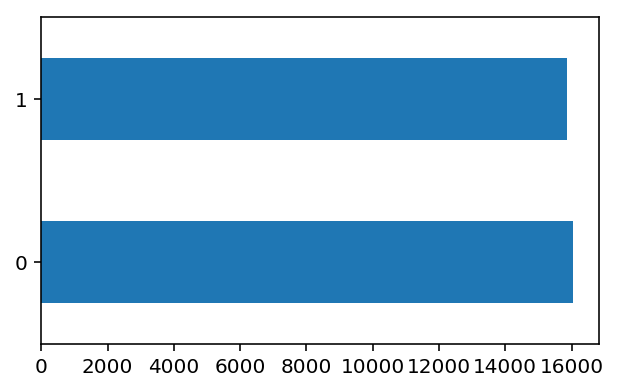

In [7]:
# Assess how this response variable `churndep` is distributed, visually
fig, ax = plt.subplots(figsize=(5, 3))
churn.churndep.value_counts().plot('barh');

YouTube - Matplotlib: How to color sections of the plot with fill_between
https://www.youtube.com/watch?v=MK8NytXli5Q

In [8]:
import pandas_profiling

pandas_profiling.ProfileReport(churn)

Number of variables,12
Number of observations,31891
Total Missing (%),0.0%
Total size in memory,2.9 MiB
Average record size in memory,96.0 B
Numeric,6
Categorical,0
Boolean,6
Date,0
Text (Unique),0
Rejected,0


# Feature Engineering

In [9]:
# important in Python: use *.copy() for a deep copy 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html#pandas.DataFrame.copy 
churn2 = churn.copy()

In [10]:
%%time
for col in ["revenue", "eqpdays"]:
    churn2[col] = np.where(churn2[col] < 0, 0, churn2[col])
# always use NumPy over Pandas for such operations - NumPy far more efficient computationally 

CPU times: user 3.1 ms, sys: 1.36 ms, total: 4.46 ms
Wall time: 2.88 ms


In [11]:
churn2["revenue"].describe()

count    31891.000000
mean        58.665363
std         44.163603
min          0.000000
25%         33.450000
50%         48.380000
75%         71.040000
max        861.110000
Name: revenue, dtype: float64

In [12]:
# #Alternative step involves removing the records with negative `revenue` & `eqpdays`, entire rows removed. 

# churn1 = churn.drop(churn[churn.revenue < 0].index)
# churn2 = churn1.drop(churn1[churn1.eqpdays < 0].index)

In [13]:
churn2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
revenue,31891.0,58.665363,44.163603,0.0,33.45,48.38,71.04,861.11
outcalls,31891.0,24.951385,34.790147,0.0,3.00,13.33,33.33,610.33
incalls,31891.0,8.065277,16.610589,0.0,0.00,2.00,9.00,404.00
months,31891.0,18.761908,9.548019,6.0,11.00,17.00,24.00,60.00
eqpdays,31891.0,391.225989,254.993312,0.0,212.00,341.00,530.00,1812.00
webcap,31891.0,0.894704,0.306939,0.0,1.00,1.00,1.00,1.00
marryyes,31891.0,0.363175,0.480922,0.0,0.00,0.00,1.00,1.00
travel,31891.0,0.057163,0.232158,0.0,0.00,0.00,0.00,1.00
pcown,31891.0,0.184817,0.388155,0.0,0.00,0.00,0.00,1.00
creditcd,31891.0,0.676931,0.467656,0.0,0.00,1.00,1.00,1.00


# Training and Visualizing a Decision Tree

In [14]:
features = ['revenue', 'outcalls', 'incalls', 'months', 'eqpdays', 'webcap', 'marryyes', 'travel', 'pcown', 
           'creditcd', 'retcalls']
X = churn2[features].values
y = churn2.churndep.values

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

#### NEED TO REVIEW:
(1) http://www.learnbymarketing.com/481/decision-tree-flavors-gini-info-gain/

(2) https://towardsdatascience.com/machine-learning-predicting-customer-churn-dd38a42774cf

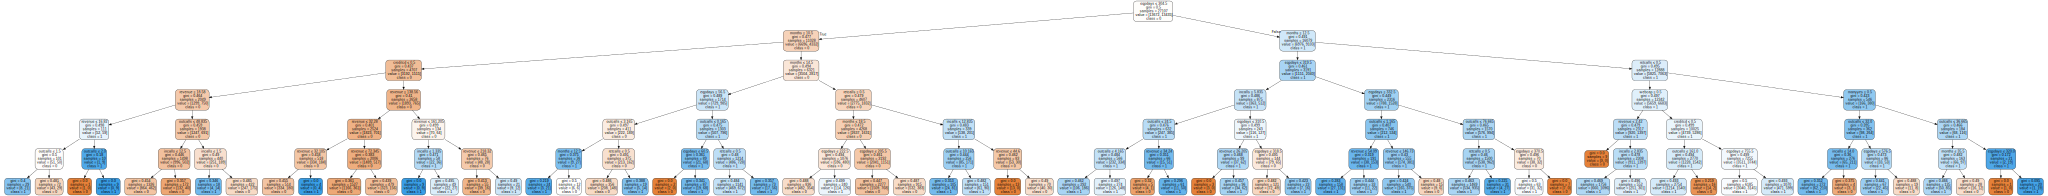

In [16]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz 

# Gini-model where criterion defaults to information gain 
clf_gini = tree.DecisionTreeClassifier(max_depth=6)
clf_gini = clf_gini.fit(X_train, y_train)
feature_names = list(features)
gini_tree = tree.export_graphviz(clf_gini, out_file=None,
                                feature_names=feature_names,
                                class_names='01',
                                filled=True, rounded=True,  
                                special_characters=True)

gini_graph = graphviz.Source(gini_tree) 
gini_graph

In [17]:
gini_graph.render(filename='gini_graph')

'gini_graph.pdf'

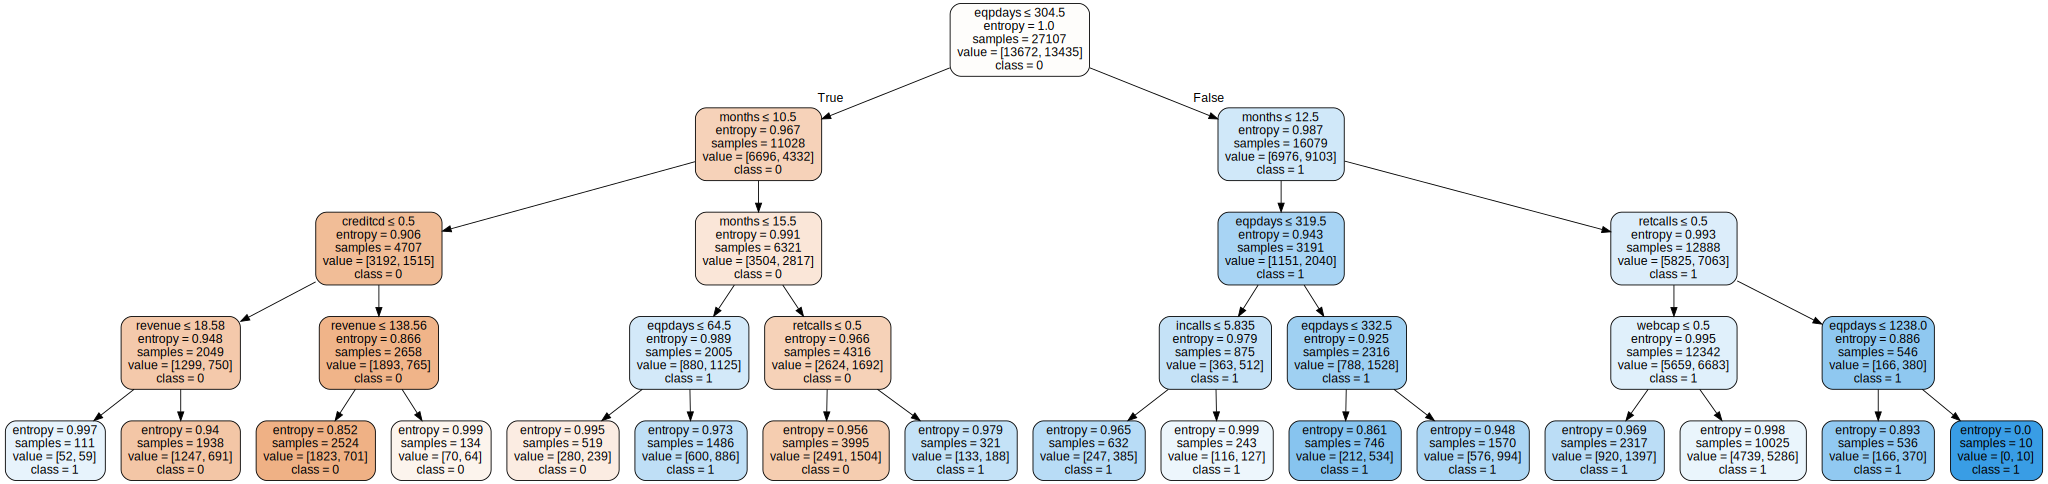

In [18]:
# Information gain
clf_infoG = tree.DecisionTreeClassifier(criterion="entropy", max_depth=4)
clf_infoG = clf_infoG.fit(X_train, y_train)
feature_names = list(features)
infoG_tree = tree.export_graphviz(clf_infoG, out_file=None,
                                feature_names=feature_names,
                                class_names='01',
                                filled=True, rounded=True,  
                                special_characters=True)

infoG_graph = graphviz.Source(infoG_tree) 
infoG_graph

In [19]:
infoG_graph.render(filename='infoG_graph')

'infoG_graph.pdf'

# Feature Importance

Matplotlib colormap codes: https://matplotlib.org/examples/color/colormaps_reference.html

In [20]:
features

['revenue',
 'outcalls',
 'incalls',
 'months',
 'eqpdays',
 'webcap',
 'marryyes',
 'travel',
 'pcown',
 'creditcd',
 'retcalls']

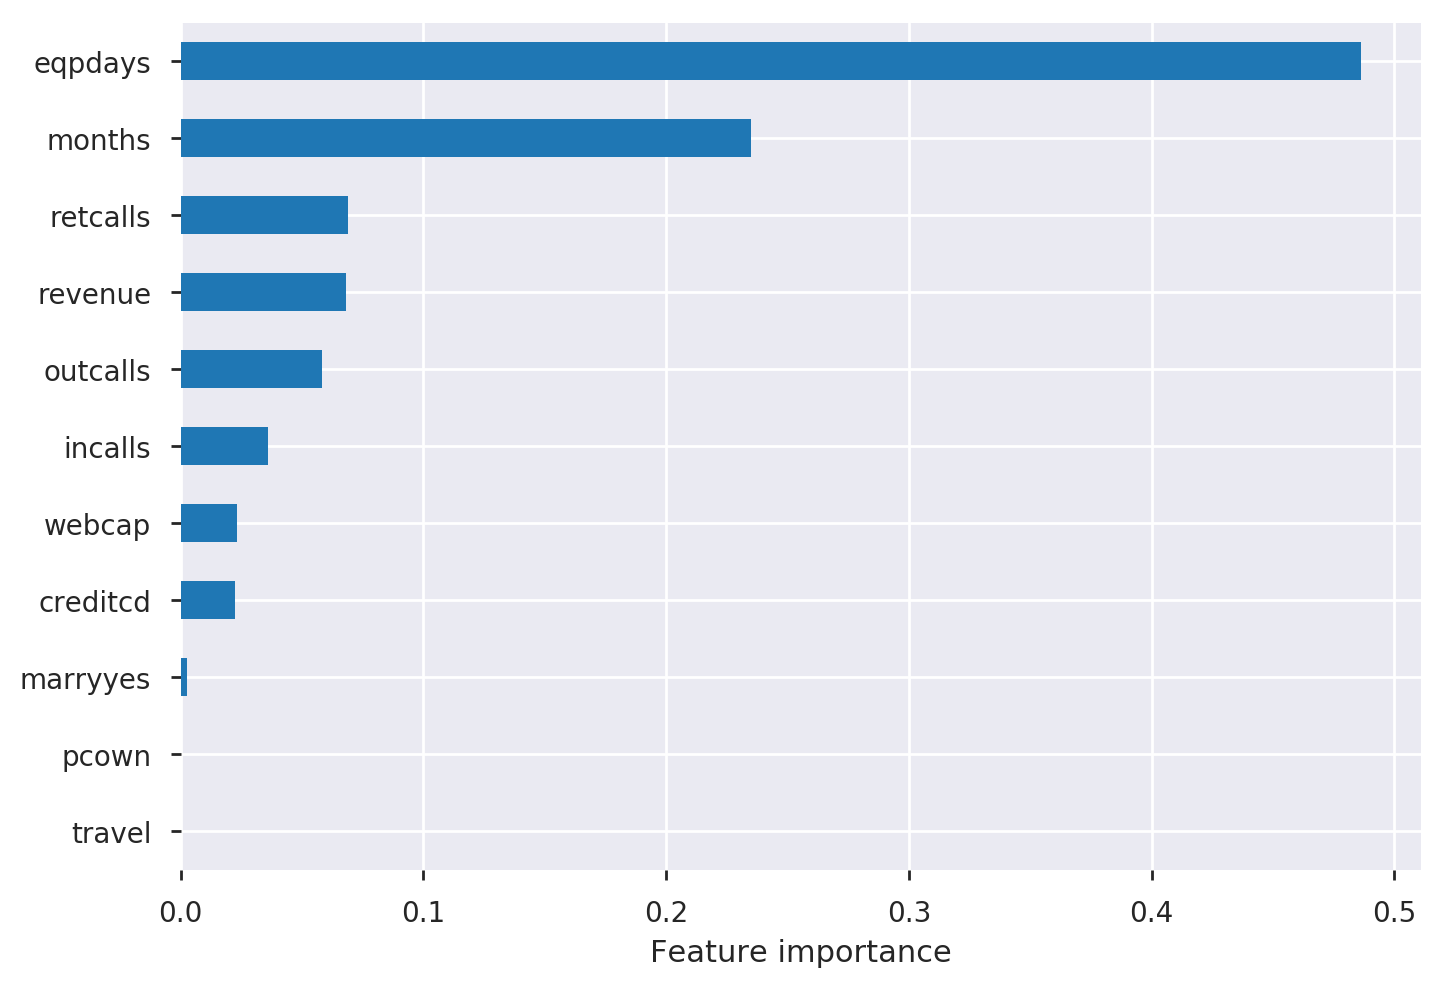

In [21]:
## Visualize importance of each feature variable
pd.Series(clf_gini.feature_importances_, index=features).sort_values().plot('barh');
plt.xlabel('Feature importance');

# Model Evaluation

https://www.unine.ch/files/live/sites/imi/files/shared/documents/papers/Gini_index_fulltext.pdf

Gini is intended for continuous attributes and Entropy is for attributes that occur in classes

    Gini is to minimize misclassification
    Entropy is for exploratory analysis

Entropy is a little slower to compute

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1045 1319]
 [ 613 1807]]
Normalized confusion matrix
[[0.44 0.56]
 [0.25 0.75]]


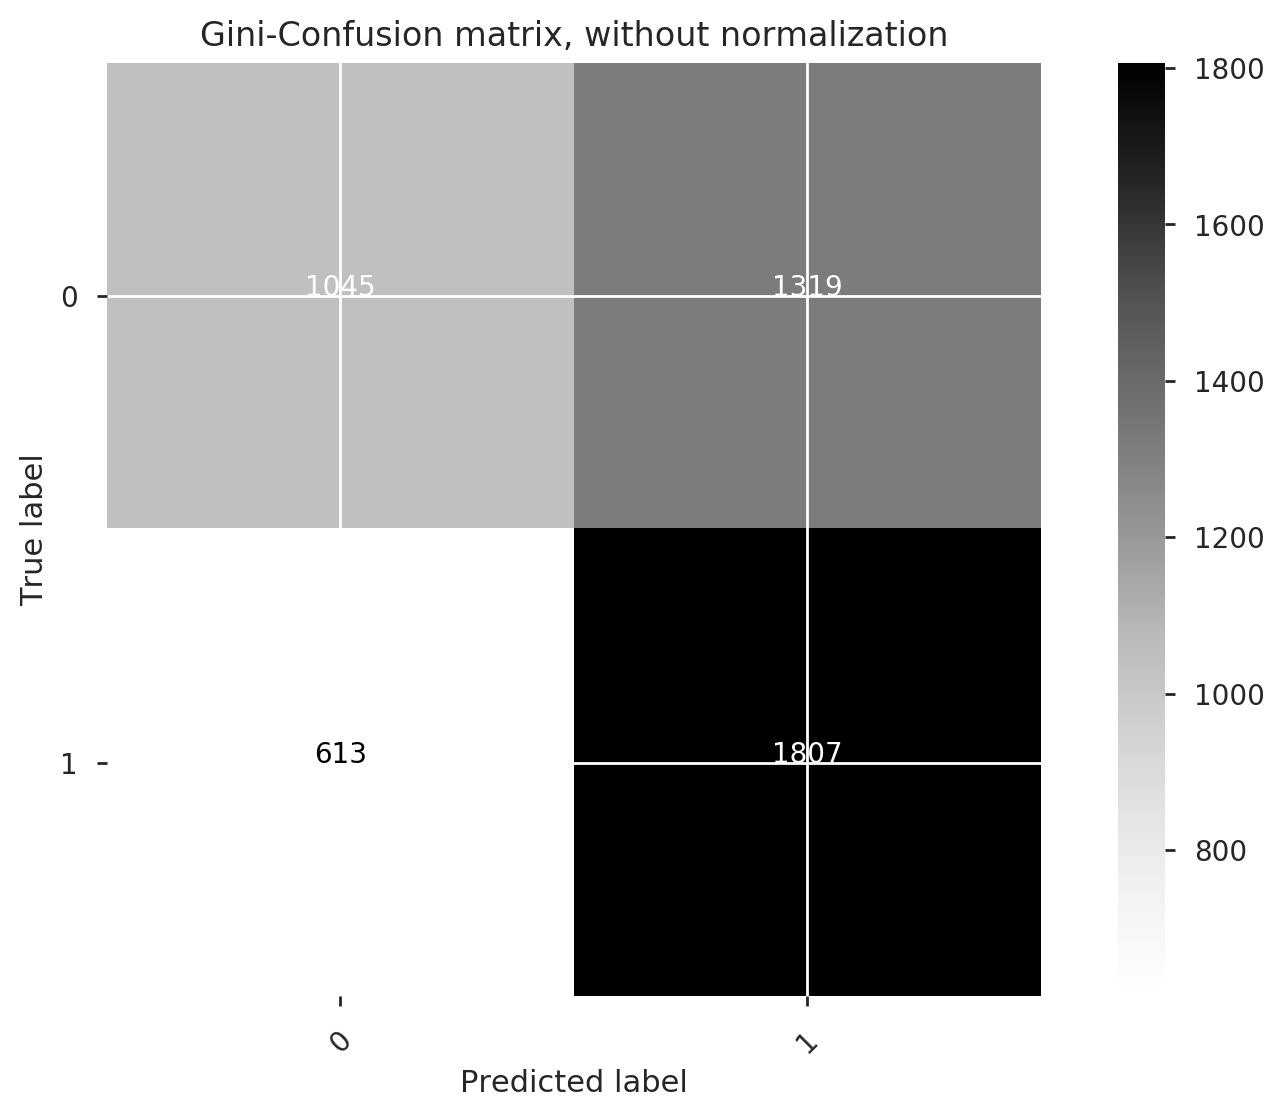

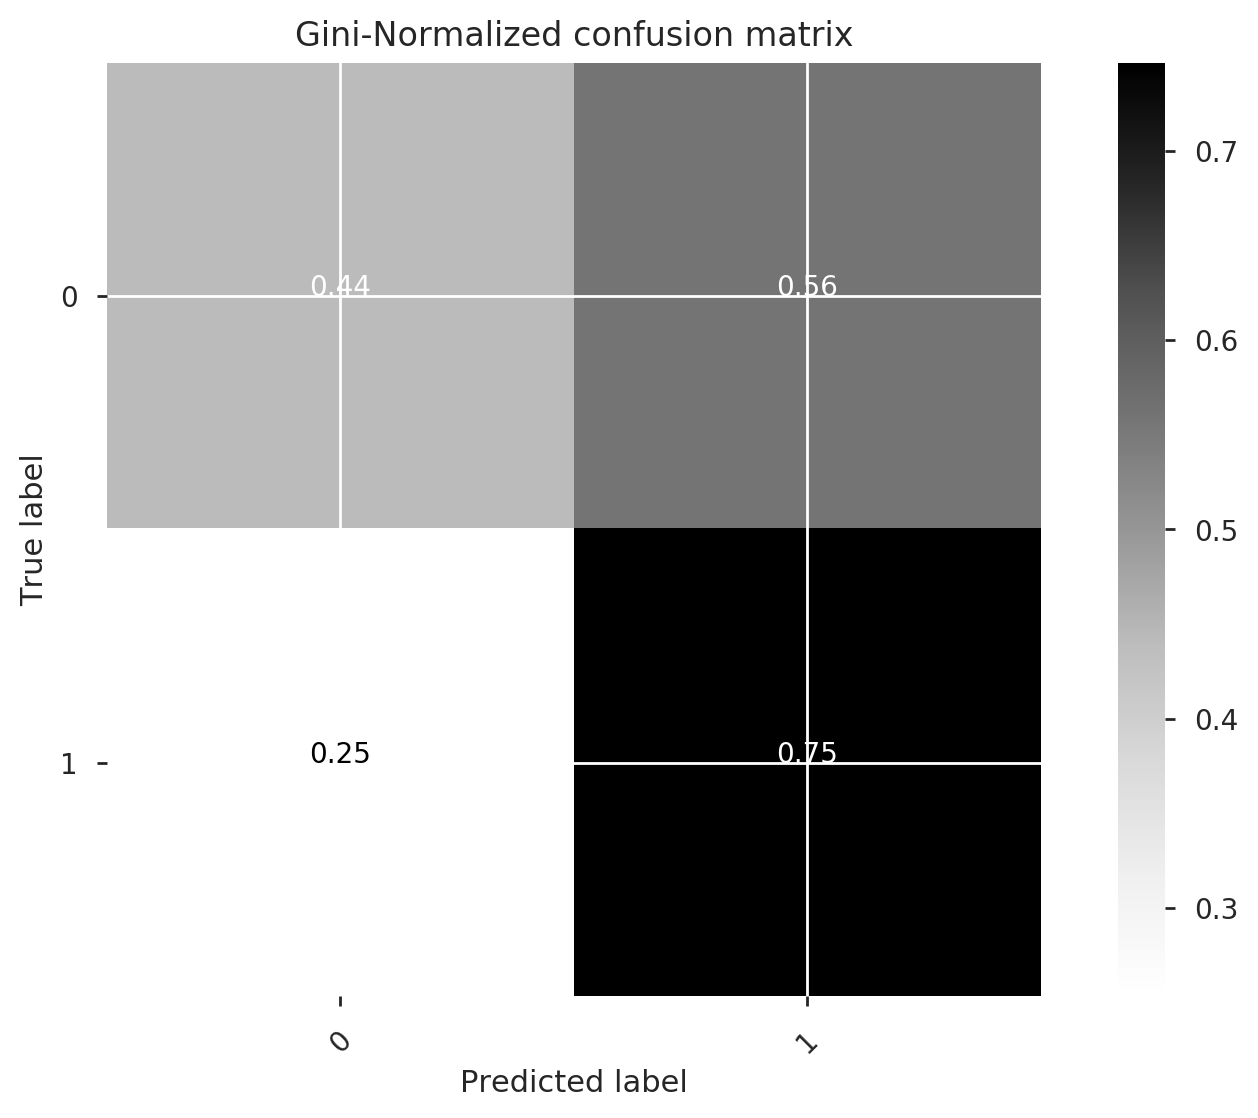

In [23]:
from sklearn.metrics import confusion_matrix

#gini model evaluation
y_pred_gini = clf_gini.fit(X_train, y_train).predict(X_test)               
gini_matrix = confusion_matrix(y_test, y_pred_gini)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(gini_matrix, classes='01',
                      title='Gini-Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(gini_matrix, classes='01', normalize=True,
                      title='Gini-Normalized confusion matrix')

plt.show()

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

gini_A = accuracy_score(y_test,y_pred_gini)
gini_P = precision_score(y_test,y_pred_gini)
gini_R = recall_score(y_test,y_pred_gini)
gini_F = f1_score(y_test,y_pred_gini)
gini_A

0.5961538461538461

In [25]:
gini_P

0.5780550223928342

In [26]:
gini_R

0.746694214876033

In [27]:
gini_F

0.6516408222142084

In [28]:
gini_classfication_error = 1 - gini_A
gini_classfication_error 

0.40384615384615385

Confusion matrix, without normalization
[[1033 1331]
 [ 589 1831]]
Normalized confusion matrix
[[0.44 0.56]
 [0.24 0.76]]


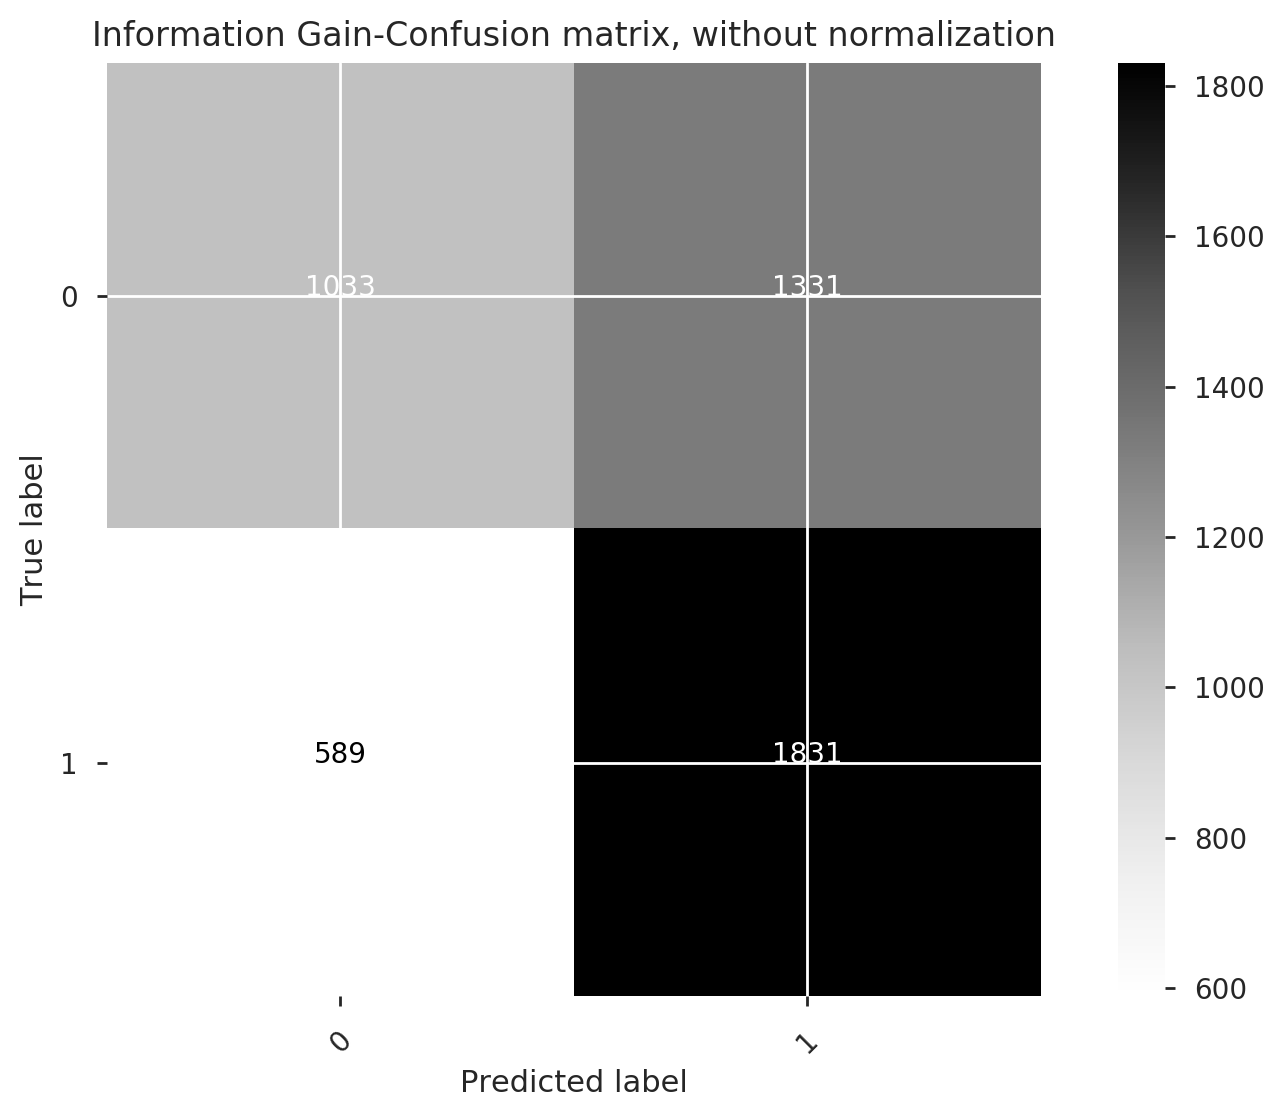

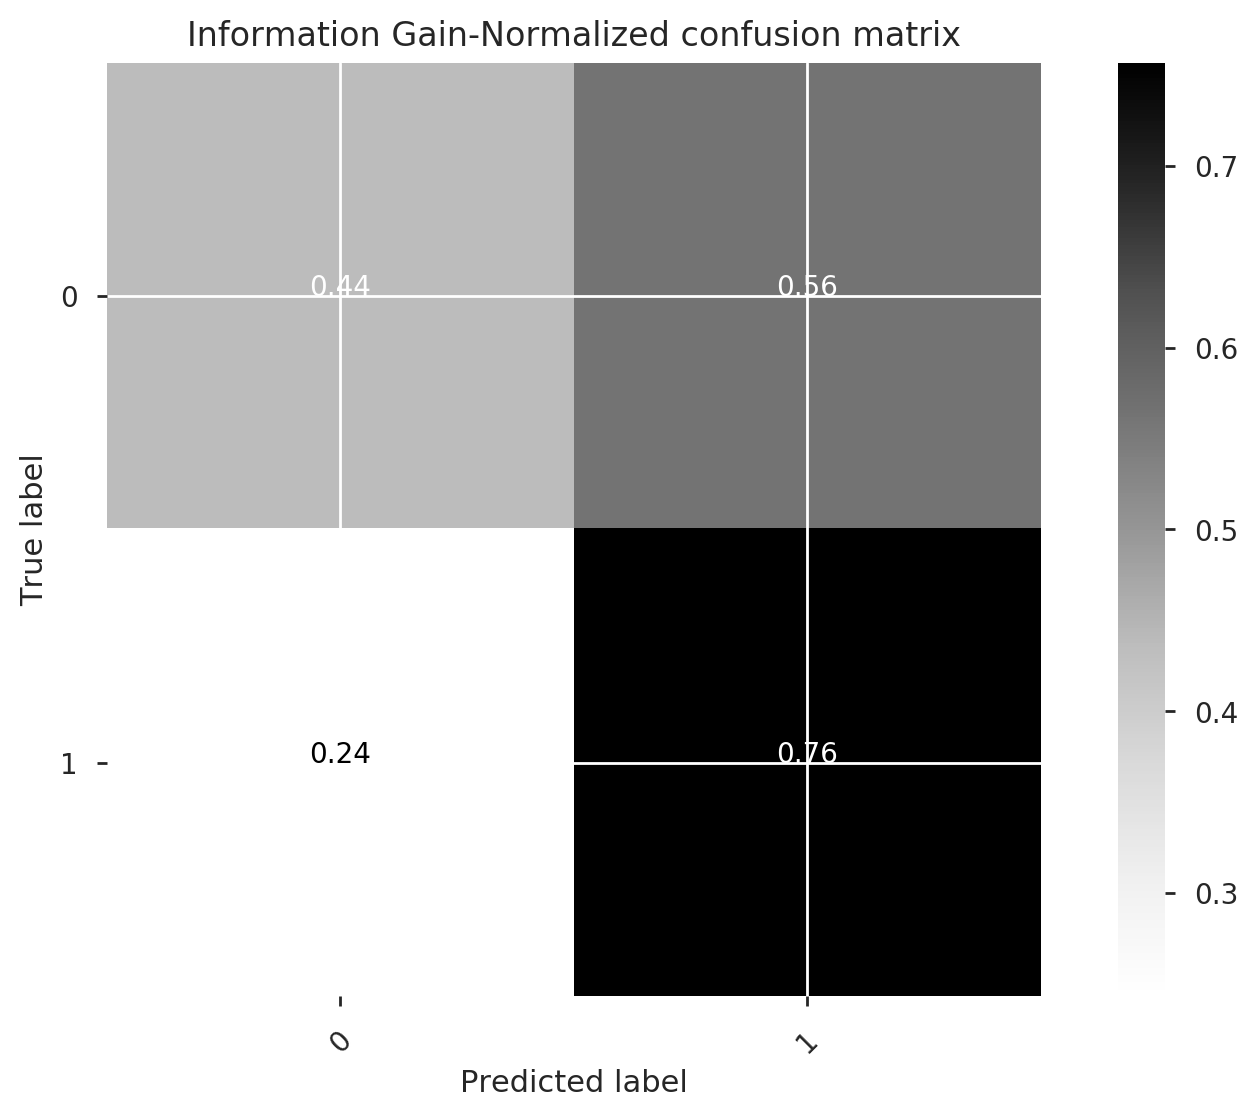

In [29]:
# information gain model evaluation
y_pred_infoG = clf_infoG.fit(X_train, y_train).predict(X_test)               
infoG_matrix = confusion_matrix(y_test, y_pred_infoG)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(infoG_matrix, classes='01',
                      title='Information Gain-Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(infoG_matrix, classes='01', normalize=True,
                      title='Information Gain-Normalized confusion matrix')

plt.show()

In [30]:
infoG_A = accuracy_score(y_test,y_pred_infoG)
infoG_P = precision_score(y_test,y_pred_infoG)
infoG_R = recall_score(y_test,y_pred_infoG)
infoG_F = f1_score(y_test,y_pred_infoG)
infoG_A

0.5986622073578596

In [31]:
infoG_P

0.5790638836179633

In [32]:
infoG_R

0.7566115702479339

In [33]:
infoG_F

0.6560372626298818

In [34]:
infoG_classfication_error = 1 - infoG_A
infoG_classfication_error

0.4013377926421404

## Advanced topics for Model Interpretability with SHAP (SHapley Additive exPlanations) & LIME (Local Interpretable Model-agnostic Explanations)

1. https://trial.dominodatalab.com/u/joshpoduska/SHAP_and_LIME/view/SHAP_and_LIME.ipynb
2. https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime/

#### Create the LIME Explainer

## Operationalizing this model

When the criterion is gain_ratio / information gain, the F-score is 0.6516.<br>
When the criterion is information_gain, the F-score is 0.6560.<br>
So, I chose information_gain `clf_infoG` model variant as the splitting criterion.

With the model I built, I can predict whether a customer will leave or not with given data. For example:
Suppose a consumer can be described as: 
"revenue = 50", "outcalls = 13", "incalls = 2", "months = 25",
"eqpdays = 270", "webcap = 1", "marryyes = 0", "travel = 0", 
"pcown = 0", "creditcd = 1", "retcalls = 3"

operational_model = clf_infoG
operational_model.fit(X, y)

Save this model offline

In [36]:
operational_model = clf_infoG

from sklearn.externals import joblib
joblib.dump(operational_model, 'decision-tree-trained.pkl')

['decision-tree-trained.pkl']

Confirm that this <i>*.pkl</i> file has been saved in the working directory

In [37]:
!ls *.pkl

decision-tree-trained.pkl


Re-load the model from the <i>*.pkl</i> file

In [38]:
working_model = joblib.load('decision-tree-trained.pkl')
working_model

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Creating a whole new person with unseen feature values.  

`['revenue', 'outcalls', 'incalls', 'months', 'eqpdays', 'webcap', 'marryyes', 'travel', 'pcown', 'creditcd', 'retcalls']])`

In [39]:
StephenMiller = [[50, 13, 2, 25, 270, 1, 0, 0, 0, 1, 3]]

In [40]:
type(StephenMiller)

list

In [41]:
print ( working_model.predict(StephenMiller) )

[1]


In [42]:
working_model.predict_proba(StephenMiller)

array([[0.41, 0.59]])

In [43]:
StephenMiller2 = [[50, 13, 2, 9, 101, 1, 0, 0, 0, 1, 3]]

In [44]:
print ( working_model.predict(StephenMiller2) )

[0]


In [45]:
working_model.predict_proba(StephenMiller2)

array([[0.72, 0.28]])

---

In [46]:
# Confirm that one-hot encoding does not alter our working dataset
churn3 = pd.get_dummies(churn2)
churn3.describe()

,revenue,outcalls,incalls,months,eqpdays,webcap,marryyes,travel,pcown,creditcd,retcalls,churndep
count,31891.000000,31891.000000,31891.000000,31891.000000,31891.000000,31891.000000,31891.000000,31891.000000,31891.000000,31891.000000,31891.000000,31891.000000
mean,58.665363,24.951385,8.065277,18.761908,391.225989,0.894704,0.363175,0.057163,0.184817,0.676931,0.044088,0.497162
std,44.163603,34.790147,16.610589,9.548019,254.993312,0.306939,0.480922,0.232158,0.388155,0.467656,0.224552,0.500000
min,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.450000,3.000000,0.000000,11.000000,212.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.380000,13.330000,2.000000,17.000000,341.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,71.040000,33.330000,9.000000,24.000000,530.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,861.110000,610.330000,404.000000,60.000000,1812.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


# Training and Testing the Classification Algorithms

Now that we have preprocessed the data and built our training and testing datasets, we can start to deploy different classification algorithms. It's relatively easy to test multiple models; as a result, we will compare and contrast the performance of ten different algorithms.

<b><i>Run times: DF & RF almost immediate, but xgboost is around 8min

In [47]:
%%time
# Now that we have our dataset, we can start building algorithms! We'll need to import each algorithm we plan on using
# from sklearn.  We also need to import some performance metrics, such as accuracy_score and classification_report.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from xgboost import XGBClassifier

from sklearn import model_selection
seed = 42

# define scoring method
scoring = 'accuracy'

# Define models to train
# names = ["Nearest Neighbors", "Gaussian Process",
#          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
#          "Naive Bayes", "SVM Linear", "SVM RBF", "SVM Sigmoid"]

# classifiers = [
#     KNeighborsClassifier(n_neighbors = 8),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=9),
#     RandomForestClassifier(max_depth=9, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=10, solver='lbfgs', hidden_layer_sizes=[100], max_iter=2000, activation='logistic'),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     SVC(kernel = 'linear', gamma='auto'), 
#     SVC(kernel = 'rbf', gamma='auto'),
#     SVC(kernel = 'sigmoid', gamma='auto')
# ]

names = ["Decision Tree", "Random Forest", "XGBoost"]

classifiers = [
    DecisionTreeClassifier(max_depth=20),
    RandomForestClassifier(max_depth=40, n_estimators=10, max_features=1),
    XGBClassifier(max_depth=100, n_jobs = -1)
]

models = list(zip(names, classifiers))

# evaluate each model in turn
results = []
names = []

print("Accuracy cross-validation average with standard deviation for each model")
for name, model in models:
    kfold = model_selection.KFold(n_splits=40, random_state = seed) # per Eugene Geis, 21 Feb 2019
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Accuracy cross-validation average with standard deviation for each model
Decision Tree: 0.547019 (0.020095)
Random Forest: 0.552954 (0.019419)
XGBoost: 0.561035 (0.022063)
CPU times: user 54min 7s, sys: 1min 42s, total: 55min 49s
Wall time: 8min 55s


In [48]:
%%time
from sklearn.metrics import roc_auc_score, roc_curve

# Remember, performance on the training data is not that important. We want to know how well our algorithms
# can generalize to new data.  To test this, let's make predictions on the validation dataset.

for name, model in list(models):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(name)
    print(accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))

# Accuracy - ratio of correctly predicted observation to the total observations. 
# Precision - (false positives) ratio of correctly predicted positive observations to the total predicted positive observations
# Recall (Sensitivity) - (false negatives) ratio of correctly predicted positive observations to the all observations in actual class - yes.
# F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false 

Decision Tree
0.5196488294314381
              precision    recall  f1-score   support

           0       0.51      0.52      0.52      2364
           1       0.53      0.52      0.52      2420

   micro avg       0.52      0.52      0.52      4784
   macro avg       0.52      0.52      0.52      4784
weighted avg       0.52      0.52      0.52      4784

Random Forest
0.5493311036789298
              precision    recall  f1-score   support

           0       0.54      0.65      0.59      2364
           1       0.57      0.45      0.50      2420

   micro avg       0.55      0.55      0.55      4784
   macro avg       0.55      0.55      0.55      4784
weighted avg       0.55      0.55      0.55      4784

XGBoost
0.56438127090301
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      2364
           1       0.57      0.56      0.56      2420

   micro avg       0.56      0.56      0.56      4784
   macro avg       0.56      0.56    

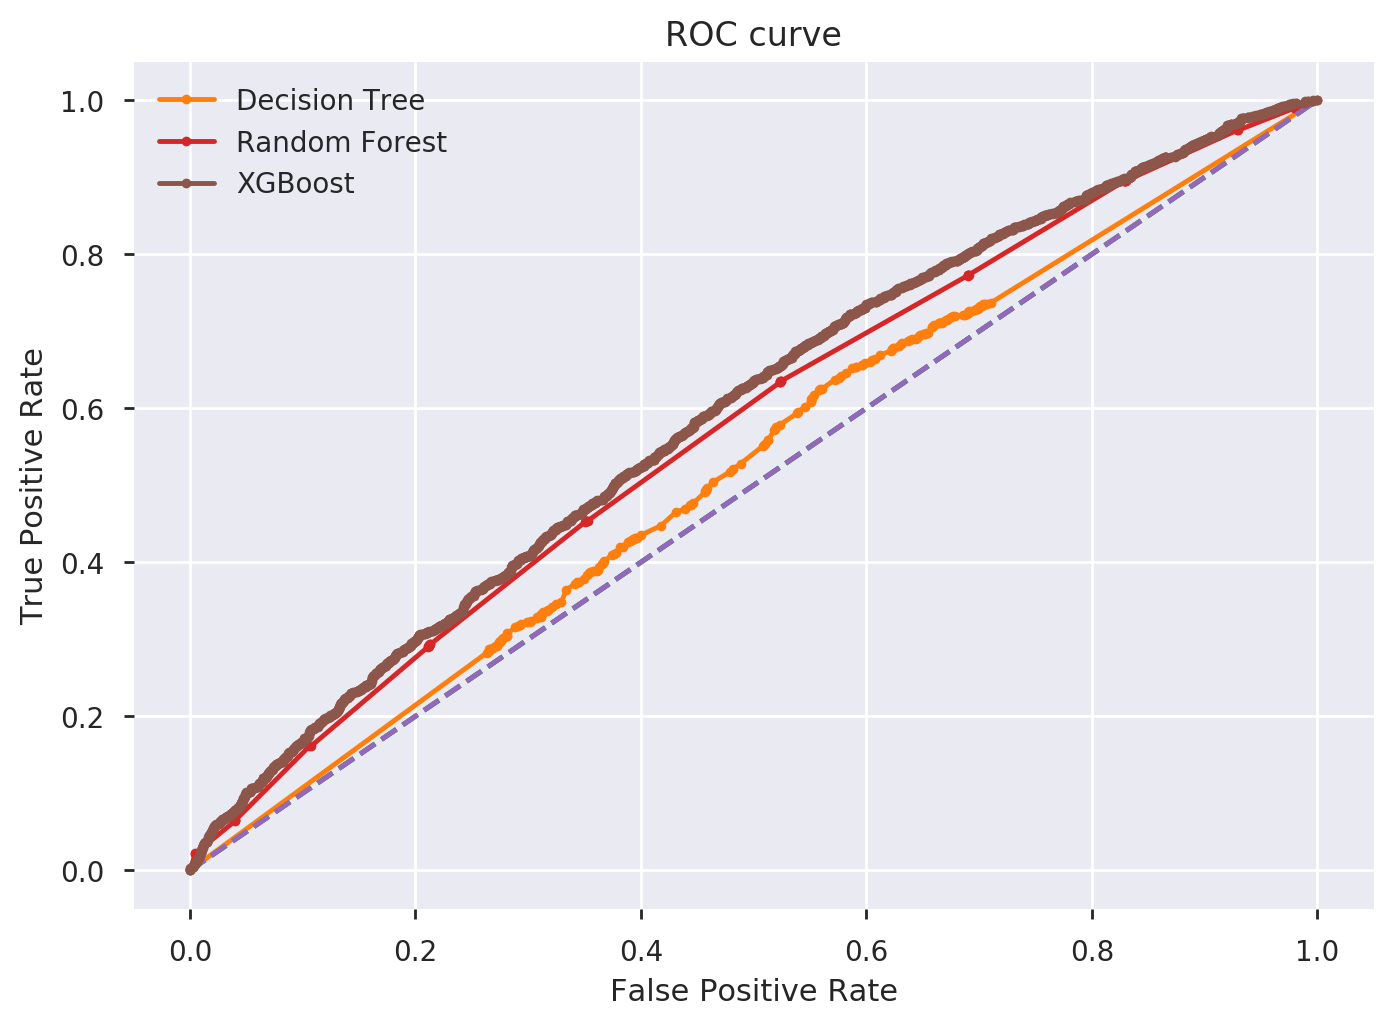

In [49]:
# ROC (Receiver operating characteristic) curve
# https://en.wikipedia.org/wiki/Receiver_operating_characteristic

for name, model in list(models):
    prob_score = []
    # predict probabilities
    prob_score = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    prob_score = prob_score[:, 0]
    fpr,tpr,thresholds = roc_curve(y_test,1-prob_score)
    # Plot the roc curve for this model
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.', label = name)
    plt.xlim([-.05, 1.05])
    plt.ylim([-.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

Keep in mind that while we are referring to AUC (based on ROC) and accuracy concurrently, they are not the same concepts <i>per se</i>.

Overall accuracy is based on one specific cutpoint, while ROC tries all of the cutpoint and plots the sensitivity and specificity. So when we compare the overall accuracy, we are comparing the accuracy based on some cutpoint. The overall accuracy varies for different tpr, fpr points.<br>
https://stats.stackexchange.com/questions/68893/area-under-curve-of-roc-vs-overall-accuracy

--- 
## Building a full model

### Commentary
This is classic p-value hacking! Picking models this way makes it very easy to increase accuracy on a training dataset by overfitting a model, which can result in poorer performance on unseen data.

Furthermore, using only one training/test split to compare models can introduce bias towards certain models and contribute to overfitting.

<b>K-fold cross validation</b> offers a solution to this problem and allows the variance to be accounted for by way of an error estimate on each accuracy calculation. This, in turn, naturally leads to the use of validation curves for tuning model parameters.

First step is constructing some necessary Python functions. 

In [ ]:
# Function to draw the validation curve

def plot_validation_curve(train_scores, test_scores,
                          param_range, xlabel='', log=False):
    '''
    This code is from scikit-learn docs:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    
    Also here:
    https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch06/ch06.ipynb
    '''
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    
    plt.plot(param_range, train_mean, 
             color=sns.color_palette('Set1')[1], marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean, 
             color=sns.color_palette('Set1')[0], linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    plt.legend(loc='lower right')
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)
    return fig

In [ ]:
# Custom function for class accuracies

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def cross_val_class_score(clf, X, y, cv = 40):
    kfold = StratifiedKFold(n_splits=cv)\
                .split(X, y)

    class_accuracy = []
    for k, (train, test) in enumerate(kfold):
        clf.fit(X[train], y[train])
        y_test = y[test]
        y_pred = clf.predict(X[test])
        cmat = confusion_matrix(y_test, y_pred)
        class_acc = cmat.diagonal()/cmat.sum(axis=1)
        class_accuracy.append(class_acc)
        print('fold: {:d} accuracy: {:s}'.format(k+1, str(class_acc)))
        
    return np.array(class_accuracy)

In [ ]:
features

X = churn2[features].values
y = churn2.churndep.values

Random Forests are an attractive algorithm and it performed reasonably well, above. Plus, Random Forests are compatible with feature sets composed of both continuous and categorical data.

A Random Forest builds multiple decision trees and merges them together to get a more accurate and stable prediction. Very simplistically, random forests are a collection of decision tress (but with notable algorithmic  differences).

In [ ]:
%%time
# Calculate a validation curve for max_depth
# using a Random Forest classifier

np.random.seed(42)
from sklearn.model_selection import validation_curve

clf = RandomForestClassifier(n_estimators=10)

max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

print('Training {} models ...'.format(len(max_depths)))
train_scores, test_scores = validation_curve(
            estimator=clf,
            X=X,
            y=y,
            param_name='max_depth',
            param_range=max_depths,
            cv=5);

Training 10 models ...
CPU times: user 5.8 s, sys: 89.4 ms, total: 5.89 s
Wall time: 5.91 s


<b>Validation curves</b> are plots of a training and validation metric as a function of some model parameter. They plot the accuracy as a function of a hyperparameter, such as the number of decision trees used in a Random Forest or the max depth.

(0, 13)

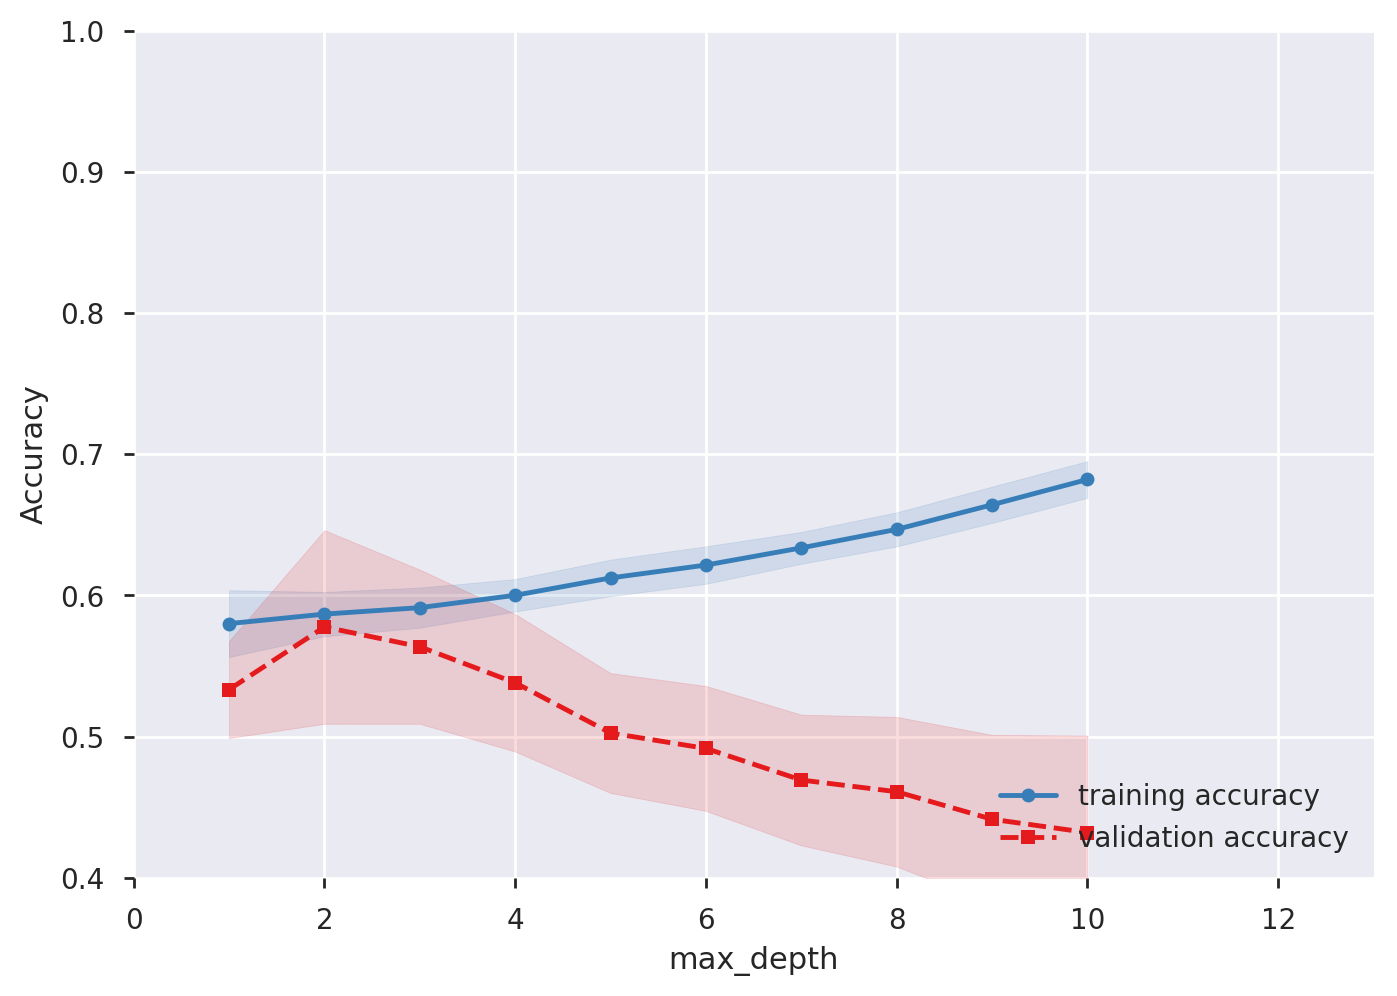

In [ ]:
plot_validation_curve(train_scores, test_scores,
                      max_depths, xlabel='max_depth')
plt.xlim(0, 13)

#### Interpreting the validation curve
Starting on the left side of the plot, we see that both training & validation results <i>generally</i> align on the accuracy score, which is good. 

In this case, we max-depth = 2 is really the best we get, where we see a point/region where the error bars of these two accuracy lines no longer overlap. The optimal value for the max_depth parameter (<i>i.e.</i>, hyperparameter) can be found by looking for a high validation score with overlapping error bars on the two lines.

In [ ]:
# Stratified k-fold cross validation
from sklearn.model_selection import cross_val_score

# Show k-fold results for the selected model:
# a random forest with max_depth = 6 or 9 and n_estimators = 200

np.random.seed(42)
clf = RandomForestClassifier(n_estimators=200, max_depth=2)
scores = cross_val_class_score(clf, X, y)

print('accuracy = {} +/- {}'.format(scores.mean(axis=0), scores.std(axis=0)))

fold: 1 accuracy: [0.04 0.98]
fold: 2 accuracy: [0.05 0.93]
fold: 3 accuracy: [0.01 0.98]
fold: 4 accuracy: [0.01 0.98]
fold: 5 accuracy: [0.01 0.99]
fold: 6 accuracy: [0.04 0.96]
fold: 7 accuracy: [0.03 0.99]
fold: 8 accuracy: [0.02 0.99]
fold: 9 accuracy: [0.04 0.99]
fold: 10 accuracy: [0.07 0.98]
fold: 11 accuracy: [0.05 0.98]
fold: 12 accuracy: [0.07 0.98]
fold: 13 accuracy: [0.14 0.96]
fold: 14 accuracy: [0.2  0.95]
fold: 15 accuracy: [0.32 0.95]
fold: 16 accuracy: [0.38 0.91]
fold: 17 accuracy: [0.38 0.94]
fold: 18 accuracy: [0.42 0.89]
fold: 19 accuracy: [0.37 0.87]
fold: 20 accuracy: [0.43 0.83]
fold: 21 accuracy: [0.45 0.78]
fold: 22 accuracy: [0.47 0.78]
fold: 23 accuracy: [0.59 0.74]
fold: 24 accuracy: [0.75 0.75]
fold: 25 accuracy: [0.77 0.74]
fold: 26 accuracy: [0.82 0.73]
fold: 27 accuracy: [0.86 0.73]
fold: 28 accuracy: [0.85 0.69]
fold: 29 accuracy: [0.8  0.55]
fold: 30 accuracy: [0.75 0.4 ]
fold: 31 accuracy: [0.79 0.35]
fold: 32 accuracy: [0.85 0.27]
fold: 33 accuracy

Text(0, 0.5, 'Accuracy')

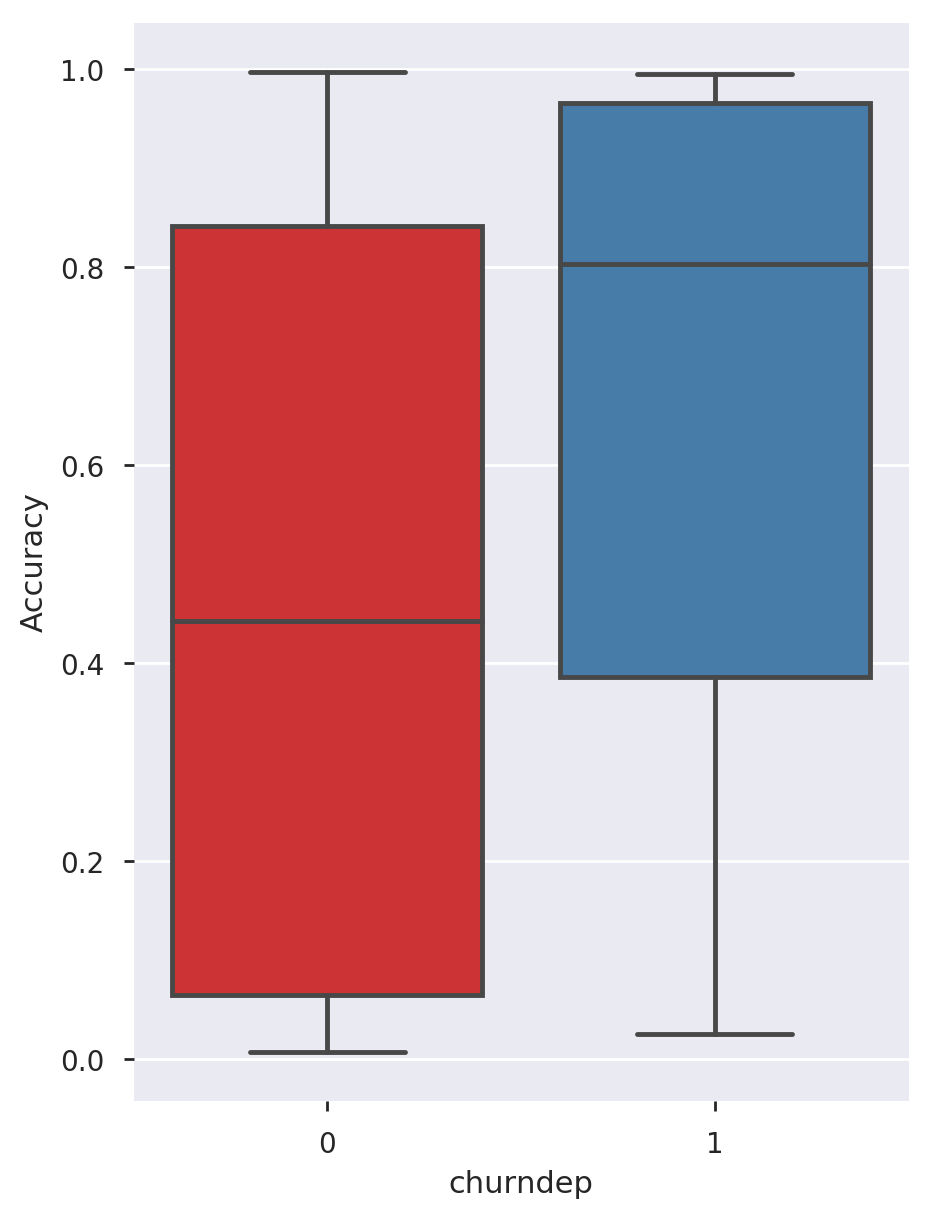

In [ ]:
# Box plot of CV results
fig = plt.figure(figsize=(5, 7))
sns.boxplot(data=pd.DataFrame(scores, columns=[0, 1]),
            palette=sns.color_palette('Set1'))
plt.xlabel('churndep')
plt.ylabel('Accuracy')

In [ ]:
# Access feature importances
d = (clf.feature_importances_, churn2.columns)
list(zip(*d))

[(0.014608535182144621, 'revenue'),
 (0.031352548410194414, 'outcalls'),
 (0.057883143872452865, 'incalls'),
 (0.3165655088196024, 'months'),
 (0.39785468167707466, 'eqpdays'),
 (0.09561804849230365, 'webcap'),
 (0.0014395165151697596, 'marryyes'),
 (0.00011152333124024302, 'travel'),
 (0.0001405766347152613, 'pcown'),
 (0.0026078400341404354, 'creditcd'),
 (0.08181807703096185, 'retcalls')]

Text(0.5, 0, 'Feature importance')

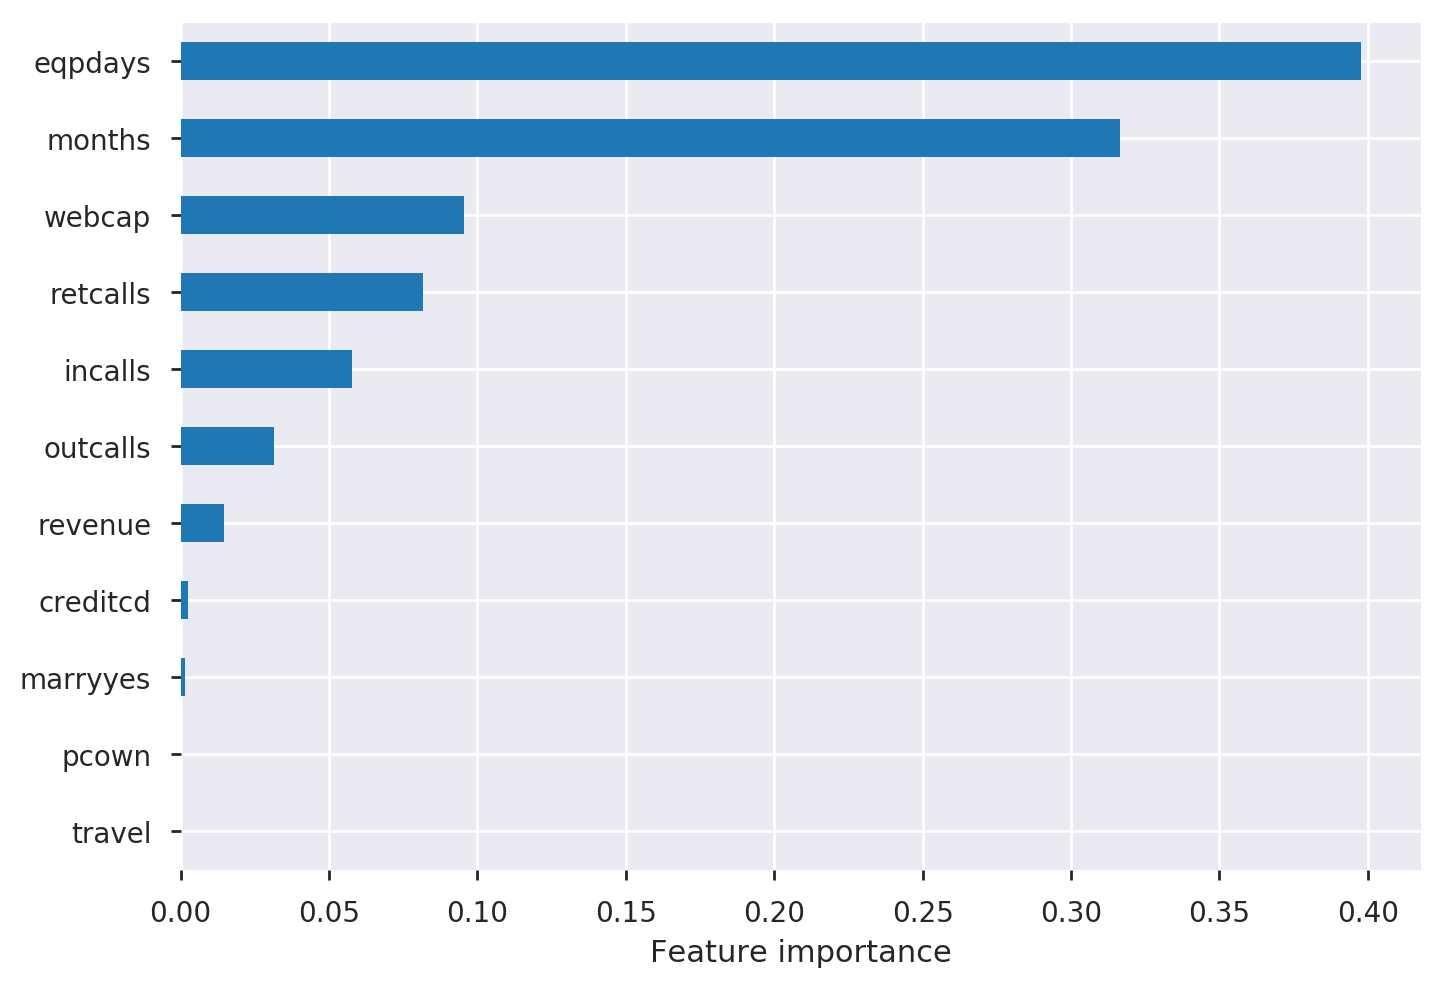

In [ ]:
# Visualize the feature importances
pd.Series(clf.feature_importances_, name='Feature importance',
            index=churn2[features].columns)\
    .sort_values()\
    .plot.barh()
plt.xlabel('Feature importance')

In [ ]:
# Print all the features with low importance

importances = list(pd.Series(clf.feature_importances_, index=churn2[features].columns)\
        .sort_values(ascending=False).index)

np.array(importances[5:])

array(['outcalls', 'revenue', 'creditcd', 'marryyes', 'pcown', 'travel'],
      dtype='<U8')

In [ ]:
from sklearn.decomposition import PCA

pca_features = ['outcalls', 'revenue', 'creditcd', 'marryyes', 'pcown', 'travel']

X_reduce = churn2[pca_features]

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_reduce)

In [ ]:
X_pca

array([[ 1.84e+01,  1.74e+01, -7.33e-01],
       [-3.76e+01,  5.88e+00,  1.84e-01],
       [-2.96e+01,  7.75e+00,  1.96e-01],
       ...,
       [ 1.34e+02, -3.85e+01,  8.34e-01],
       [ 9.11e+01, -1.96e+01, -5.65e-01],
       [ 3.23e+02, -2.36e+02,  7.88e-02]])

In [ ]:
X_pca.size

95673

In [ ]:
X_pca.shape

(31891, 3)

In [ ]:
churn4 = churn2.copy()

In [ ]:
# Add principal components to new copy of `churn` dataframe

churn4['first_principle_component'] = X_pca.T[0]
churn4['second_principle_component'] = X_pca.T[1]
churn4['third_principle_component'] = X_pca.T[2]

In [ ]:
# Select reduced-dimension feature set

features = ['eqpdays', 'months', 'retcalls', 'webcap', 'incalls',
            'first_principle_component',
            'second_principle_component',
            'third_principle_component']

X = churn4[features].values
y = churn4.churndep.values

In [ ]:
# Show k-fold results for the selected model with reduced dimensionality:
# a random forest with max_depth = 6 or 9, and n_estimators = 200

np.random.seed(42)
clf = RandomForestClassifier(n_estimators=200, max_depth=2)
scores = cross_val_class_score(clf, X, y)

print('accuracy = {} +/- {}'.format(scores.mean(axis=0), scores.std(axis=0)))

fold: 1 accuracy: [0.03 0.98]
fold: 2 accuracy: [0.03 0.94]
fold: 3 accuracy: [0.01 0.98]
fold: 4 accuracy: [0.01 0.98]
fold: 5 accuracy: [0.01 0.99]
fold: 6 accuracy: [0.02 0.99]
fold: 7 accuracy: [0.03 0.99]
fold: 8 accuracy: [0.02 0.99]
fold: 9 accuracy: [0.04 0.99]
fold: 10 accuracy: [0.07 0.98]
fold: 11 accuracy: [0.05 0.98]
fold: 12 accuracy: [0.08 0.97]
fold: 13 accuracy: [0.13 0.96]
fold: 14 accuracy: [0.2  0.96]
fold: 15 accuracy: [0.31 0.95]
fold: 16 accuracy: [0.38 0.92]
fold: 17 accuracy: [0.38 0.94]
fold: 18 accuracy: [0.43 0.89]
fold: 19 accuracy: [0.37 0.86]
fold: 20 accuracy: [0.45 0.82]
fold: 21 accuracy: [0.45 0.77]
fold: 22 accuracy: [0.48 0.77]
fold: 23 accuracy: [0.61 0.72]
fold: 24 accuracy: [0.74 0.76]
fold: 25 accuracy: [0.77 0.74]
fold: 26 accuracy: [0.82 0.7 ]
fold: 27 accuracy: [0.86 0.71]
fold: 28 accuracy: [0.84 0.66]
fold: 29 accuracy: [0.8  0.55]
fold: 30 accuracy: [0.74 0.41]
fold: 31 accuracy: [0.79 0.35]
fold: 32 accuracy: [0.85 0.27]
fold: 33 accuracy

Text(0, 0.5, 'Accuracy')

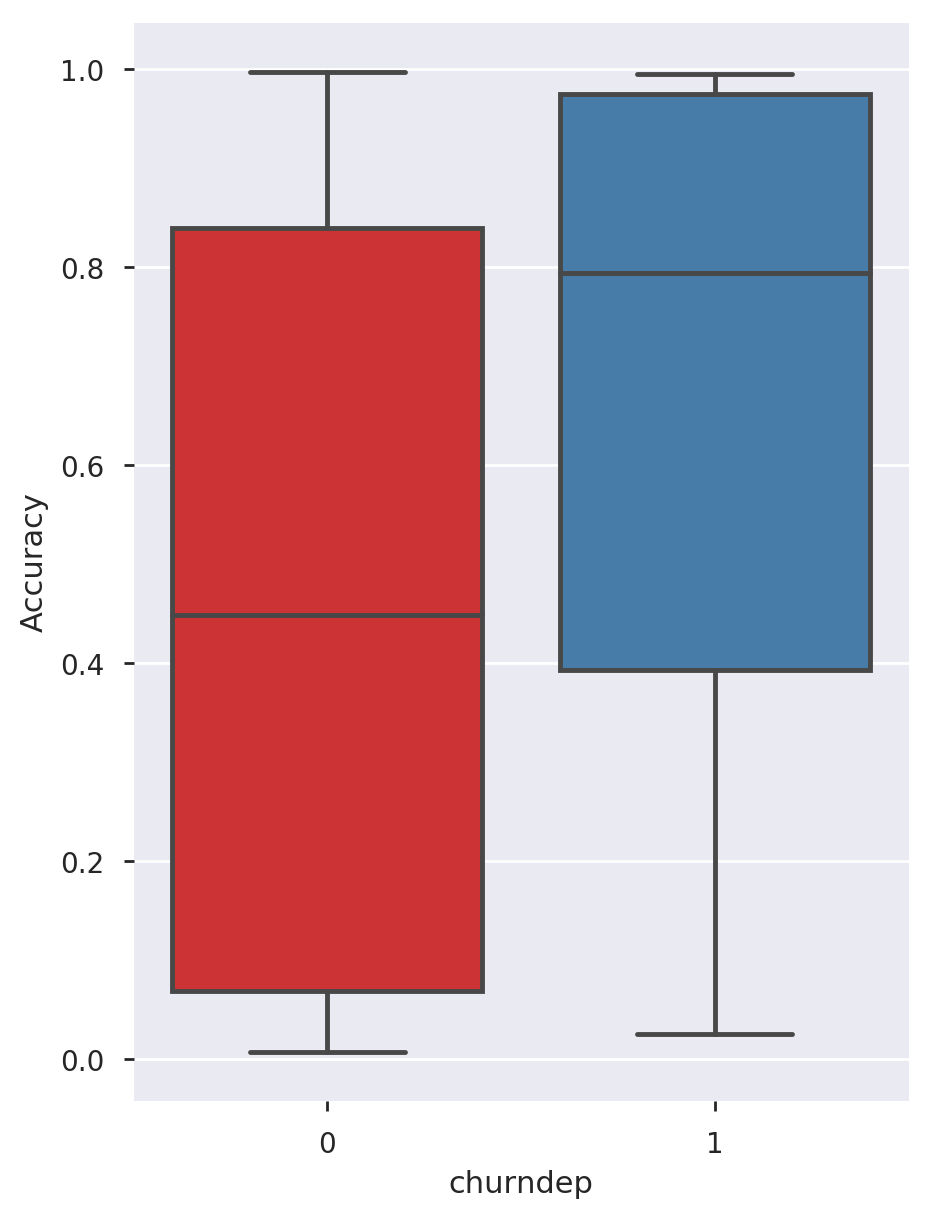

In [ ]:
# Box plot of CV results
fig = plt.figure(figsize=(5, 7))
sns.boxplot(data=pd.DataFrame(scores, columns=[0, 1]),
            palette=sns.color_palette('Set1'))
plt.xlabel('churndep')
plt.ylabel('Accuracy')

Comparing this to the previous boxplot before dimensionality reduction, we find a tighter accuracy (low spread) for churndep class=1 but it is significantly lower accuracy! The average accuracy of 37.8% can be compared to the accuracy of 68.9% prior to dimensionality reduction, so PCA is <i>not useful</i> for this case. 

---
## Advanced ML using H2O

In [ ]:
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

h2o.init(min_mem_size = "15g")

# from h2o.estimators.deepwater import H2ODeepWaterEstimator 
## Cannot build a Deep Water model - no backend found.
#if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/mashrukzahid/miniconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/3p/g_f3ln4j6x13kklzvp9y76h80000gn/T/tmp5tug1cwb
  JVM stdout: /var/folders/3p/g_f3ln4j6x13kklzvp9y76h80000gn/T/tmp5tug1cwb/h2o_mashrukzahid_started_from_python.out
  JVM stderr: /var/folders/3p/g_f3ln4j6x13kklzvp9y76h80000gn/T/tmp5tug1cwb/h2o_mashrukzahid_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,11 days
H2O cluster name:,H2O_from_python_mashrukzahid_ben2xo
H2O cluster total nodes:,1
H2O cluster free memory:,14.38 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Rather than taking the same train, test split tables, we will use churn2 as H2OFrame for modeling. 

In [ ]:
churn_hx = h2o.H2OFrame(churn2)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
churn_hx.describe()

Rows:31891
Cols:12




,revenue,outcalls,incalls,months,eqpdays,webcap,marryyes,travel,pcown,creditcd,retcalls,churndep
type,real,real,real,int,int,int,int,int,int,int,int,int
mins,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,58.66536264149765,24.951385030259242,8.065277037408684,18.761907748267525,391.2259885234056,0.8947038349377567,0.36317456335643283,0.05716346304600044,0.18481703301872002,0.6769307955222477,0.044087673638330625,0.4971622087736352
maxs,861.11,610.33,404.0,60.0,1812.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0
sigma,44.163603210612294,34.79014729213504,16.610588615571857,9.54801890230053,254.99331162108192,0.30693946775873354,0.4809220854565667,0.23215833302284344,0.3881551515571974,0.4676562320805252,0.22455228658234738,0.49999978613648655
zeros,6,4079,9651,0,50,3358,20309,30068,25997,10303,30602,16036
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,83.53,20.0,1.0,31.0,745.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0
1,29.99,0.0,0.0,52.0,1441.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0
2,37.75,2.67,0.0,25.0,572.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0


In [ ]:
for i in ['webcap', 'marryyes', 'travel', 'pcown', 'creditcd', 'churndep']:
    churn_hx[i] = churn_hx[i].asfactor()

In [ ]:
churn_hx.types

{'revenue': 'real',
 'outcalls': 'real',
 'incalls': 'real',
 'months': 'int',
 'eqpdays': 'int',
 'webcap': 'enum',
 'marryyes': 'enum',
 'travel': 'enum',
 'pcown': 'enum',
 'creditcd': 'enum',
 'retcalls': 'int',
 'churndep': 'enum'}

In [ ]:
churn_hx.summary()

,revenue,outcalls,incalls,months,eqpdays,webcap,marryyes,travel,pcown,creditcd,retcalls,churndep
type,real,real,real,int,int,enum,enum,enum,enum,enum,int,enum
mins,0.0,0.0,0.0,6.0,0.0,,,,,,0.0,
mean,58.66536264149765,24.951385030259242,8.065277037408684,18.761907748267525,391.2259885234056,,,,,,0.044087673638330625,
maxs,861.11,610.33,404.0,60.0,1812.0,,,,,,4.0,
sigma,44.163603210612294,34.79014729213504,16.610588615571857,9.54801890230053,254.99331162108192,,,,,,0.22455228658234738,
zeros,6,4079,9651,0,50,,,,,,30602,
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,83.53,20.0,1.0,31.0,745.0,1,0,0,0,0,4.0,1
1,29.99,0.0,0.0,52.0,1441.0,0,0,0,1,1,3.0,1
2,37.75,2.67,0.0,25.0,572.0,0,0,0,1,1,3.0,1


In [ ]:
predictors = list(set(churn_hx.names))

predictors.remove('churndep')
response = "churndep"

predictors

['months',
 'marryyes',
 'eqpdays',
 'incalls',
 'webcap',
 'creditcd',
 'pcown',
 'outcalls',
 'retcalls',
 'revenue',
 'travel']

In [ ]:
r = churn_hx.runif(seed = 42)
train = churn_hx[r  < 0.8]                 ## 80% for training
valid = churn_hx[(r >= 0.8) & (r < 0.9)]   ## 10% for early stopping (only enabled by default for Deep Water)
test  = churn_hx[r  >= 0.9]                ## 10% for final testing
print(train.dim)
print(valid.dim)
print(test.dim)

[25601, 12]
[3050, 12]
[3240, 12]


In [ ]:
from h2o.automl import H2OAutoML

In [ ]:
%%time

aml = H2OAutoML(max_models = 18, seed = 42, max_runtime_secs = 400)
aml.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

aml.leaderboard

AutoML progress: |███████████████████████████████████████

In [ ]:
aml.leader

In [ ]:
# Evaluate performance on a test set
perf = aml.leader.model_performance(test)
perf

In [ ]:
perf.plot()

In [ ]:
h2o.cluster().shutdown()

In [ ]:
# https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

requirements

In [ ]:
import sys
sys.version